In [3]:
%load_ext autoreload
%autoreload 2
from textwrap import wrap
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import re
import tqdm
SENTENCE_DIM = 10
survey_orig = pd.read_csv('ugb_data/survey_fcasts.yr4.tab', delimiter='\t',
                dtype={'value': float, 'answer_option': str, 'ifp_id': str, 'user_id': int})
survey_orig['timestamp'] = pd.to_datetime(survey_orig['timestamp'])
ifps = pd.read_csv('ugb_data/ifps.csv', delimiter=',', encoding='latin-1')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import re
import datetime
from collections import namedtuple
from collections import Counter
from collections import defaultdict
from itertools import chain

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

class BagOfWords(object):
    def __init__(self):
        self.base = None
        self.invalid_pattern = r'[^a-zA-Z0-9 ]'
        
    def fit(self, corpus):
        """ Train the bag-of-words algorithm.
        
        Args:
            corpus: A string.
            
        The algorithm will split `corpus` according to white space, after
        stripping it of any non-alphanumeric (or whitespace) characters.
        It will then assign an arbitrary ordering to the unique words
        found thusly.
        """
        words = re.sub(self.invalid_pattern, '', corpus).lower()
        words = set(words.split())
        self.base = {w: w_id for w_id, w in enumerate(list(words))}
            
        
    def transform(self, sentence):
        """ Encode a sentence using the bag-of-words representation.
        
        Args:
            sentence: A string.
            
        Returns:
            bow: List of ints.       
        """
        words = Counter(re.sub(self.invalid_pattern, '', sentence).split())
        bow = [0] * len(self.base)
        for key, itm in words.items():
            try:
                bow[self.base[key.lower()]] = itm
            except KeyError:
                pass
        return bow

""" Transform the tasks into vectors. """
bow = BagOfWords()
bow.fit(' '.join(chain(ifps['short_title'])))
tasks = np.array([bow.transform(task) for task in ifps['short_title']])
pca = PCA(n_components=SENTENCE_DIM, whiten=True).fit(tasks)
sentence2vec = lambda s: pca.transform([bow.transform(s)])

""" Create a function that takes the id of a task/question, and
return a list of named tuples representing bets that happened
in this task. """
Bet = namedtuple('Bet', ['delay', 'value'])

In [4]:
all_users = survey_orig['user_id'].unique()
task_ids = list(set(survey_orig['ifp_id']))
task_ids = [t_id for t_id in task_ids if ifps[ifps['ifp_id'] == t_id]['q_status'].values[0] == 'closed']

def get_data(task_id, user_ids):
    # Only keep the chosen users.
    survey = survey_orig[survey_orig['user_id'].isin(user_ids)]
    # Find the task.
    task = ifps.loc[ifps['ifp_id'] == task_id].iloc[0]
    
    # Extract bets.
    bets = defaultdict(list)
    task_selector = survey['ifp_id'] == task['ifp_id']
    time_zero = datetime.datetime.strptime(task['date_suspend'], '%m/%d/%Y %H:%M')

    survey = survey[task_selector].transform(
        {'user_id': lambda x: x,
         'answer_option': lambda x: ord(x) - 97,
         'value': lambda x: x,
         'timestamp': lambda t: (pd.to_datetime(t) - time_zero).seconds / (24 * 3600.)})
    for group in survey.groupby(['user_id', 'timestamp']):
        bets[group[0][0]].append(Bet(group[0][1], group[1]['value'].values[:task['n_opts']]))
        
    # Embed the task question in a vector space.
    question_embed = sentence2vec(task['short_title'])
    return {'q_text': task['q_text'],
            'q_answers': task['options'],
            'n_opts': task['n_opts'],
            'q_vector': question_embed, 
            'outcome': ord(task['outcome']) - 97,
            'bets': bets}

In [19]:
get_data(task_ids[10], all_users[:4])

{'bets': defaultdict(list,
             {3304: [Bet(delay=0.30777777777777776, value=array([ 0.2,  0.8])),
               Bet(delay=1.5691666666666666, value=array([ 0.2,  0.8])),
               Bet(delay=3.2633333333333332, value=array([ 0.17,  0.83])),
               Bet(delay=5.8186111111111112, value=array([ 0.1,  0.9])),
               Bet(delay=6.6011111111111109, value=array([ 0.15,  0.85])),
               Bet(delay=7.9202777777777778, value=array([ 0.05,  0.95])),
               Bet(delay=9.6408333333333331, value=array([ 0.17,  0.83])),
               Bet(delay=11.35, value=array([ 0.25,  0.75])),
               Bet(delay=13.021666666666667, value=array([ 0.25,  0.75])),
               Bet(delay=13.046111111111111, value=array([ 0.3,  0.7]))],
              4440: [Bet(delay=0.46666666666666667, value=array([ 0.05,  0.95])),
               Bet(delay=2.9244444444444446, value=array([ 0.1,  0.9])),
               Bet(delay=3.4088888888888889, value=array([ 0.8,  0.2])),
        

A Jupyter Widget

703.624155908823
89.57253032922745
43.57299967110157
89.43094545602798
71.13097497820854
58.905215322971344
49.993616938591
28.118686333298683
26.613700732588768
32.766889572143555



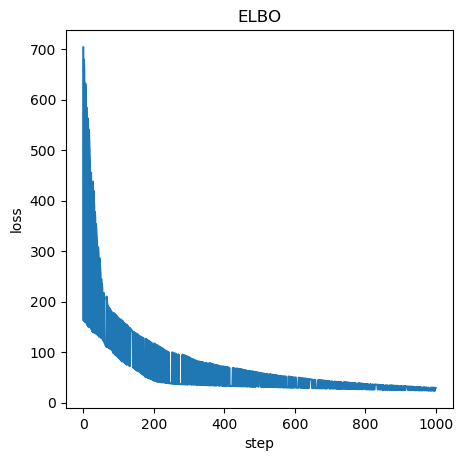

In [22]:
""" Super-simple use-case: learn each user's characteristic rate of betting. """
import torch
from torch.distributions import constraints
import pyro
import pyro.distributions as dist
import pyro.optim
import pyro.infer
pyro.enable_validation(False)

def renormalize(vals, delta=1e-5):
    # Take a discrete probability distribution and 
    # make sure there's no zero values.
    vals += delta
    vals /= vals.sum()
    return vals

pyro.clear_param_store()
allnbets = []
def model(data, users=all_users):
    n_users = len(users)
    bets = defaultdict(list)
    
    # Define the priors.
    nbet_rates = pyro.sample(
        'nbet_rates',
        dist.Normal(torch.zeros(n_users), 100 + torch.zeros(n_users)))
    
    delay_rates = pyro.sample(
        'delay_rates',
        dist.Normal(torch.zeros(n_users), 10 + torch.zeros(n_users)))
    
    alphas = pyro.sample(
        'value_ccts',
        dist.Normal(1 + torch.zeros(n_users), 1 + torch.zeros(n_users)))
    
    # Define the generative model.
    for user_id, user in enumerate(users):
        true_n_bets = torch.FloatTensor([len(data['bets'][user])])
        
        # Each user chooses how many times they'll bet by sampling
        # a Poisson distribution with a user-specific rate parameter.
        # The posterior rate is also a function of the task (see guide).
        n_bets = pyro.sample(
            'nbets_{}'.format(user),
            dist.Poisson(torch.abs(nbet_rates[user_id])),
            obs=true_n_bets)
        
        for bet_id in range(int(n_bets.item())):
            true_delay = torch.FloatTensor([data['bets'][user][bet_id].delay])
            
            # The delay of each bet is an i.i.d. sample from an
            # exponential distribution, with a user-specific rate
            # parameter. The posterior delay is also a function of
            # the current task (see guide).
            delay = pyro.sample(
                'delay_{}_{}'.format(user_id, bet_id),
                dist.Exponential(torch.abs(delay_rates[user_id])),
                obs=true_delay)
            
            # The value of each bet is an i.i.d. sample from a
            # Dirichlet distribution, bit a user-specific concentration
            # parameter. The posterior concentration is also a function 
            # of the current task (see guide).
            true_value = data['bets'][user][bet_id].value
            true_value = torch.FloatTensor(renormalize(true_value))
            value = pyro.sample(
                'value_{}_{}'.format(user_id, bet_id),
                dist.Dirichlet(torch.abs(alphas[user_id]) * torch.ones(int(data['n_opts']))),
                obs=true_value)
        
            bets[user].append(Bet(delay, value))
        
    return bets

def guide(data, users=all_users):
    n_users = len(users)
    
    # Define an amortized posterior for the number of bets rate.
    a = pyro.param('a_nbets', torch.randn(n_users, SENTENCE_DIM))
    b = pyro.param('b_nbets', torch.randn(n_users, 1))
    mean = torch.t(torch.FloatTensor(data['q_vector']))
    mean = torch.matmul(a, mean) + b
    bet_rates = pyro.sample('nbet_rates', dist.Delta(mean.squeeze()))

    # Define an amortized posterior for the bet delay rate.
    a = pyro.param('a_delays', torch.randn(n_users, SENTENCE_DIM))
    b = pyro.param('b_delays', torch.randn(n_users, 1))
    mean = torch.t(torch.FloatTensor(data['q_vector']))
    mean = torch.matmul(a, mean) + b
    delay_rates = pyro.sample('delay_rates', dist.Delta(mean.squeeze()))
    
    # Define an amortized posterior for the bet value concentration.
    a = pyro.param('a_values', torch.randn(n_users, SENTENCE_DIM))
    b = pyro.param('b_values', torch.randn(n_users, 1))
    mean = torch.t(torch.FloatTensor(data['q_vector']))
    mean = torch.matmul(a, mean) + b
    value_ccts = pyro.sample('value_ccts', dist.Delta(mean.squeeze()))
    
    return bet_rates, delay_rates, value_ccts

svi = pyro.infer.SVI(model=model,
                     guide=guide,
                     optim=pyro.optim.SGD({"lr": 0.0001}),
                     loss=pyro.infer.Trace_ELBO())

losses = []
means = []
usrs = set(all_users[:10])
tasks = task_ids[:2]

for t_id, t in enumerate(tqdm.tqdm_notebook(range(1000))):
    bets = get_data(np.random.choice(tasks), usrs)
    losses.append(svi.step(bets, list(usrs)))
    if t_id % 100 == 0:
         print(losses[-1])

plt.figure(figsize=(5, 5), facecolor='white', dpi=100)
plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss")

A Jupyter Widget

2456.60179781029
2701.6229258384556
4073.849646512419
5159.508785456419
4808.368669087067
1405.604205623269
21348.89283453673
4067.960137594142
28570.17686038837
28614.05396761
11130.913121923804
12091.900026135409
19071.644039526815
33110.323223255575
3394.112414356321
7021.460935136536
13159.313873969018
6154.8992533273995
3631.463468506001
4432.037246979773
7016.832650732249
2318.0543778911233
19631.610638827085
1772.2187383286655
4841.690367281437
8345.967501219362
1773.3130496498197
2407.54173104465
3600.006545137614
4558.09311388433
46474.39387800358
99309.57470040768
11511.010479578748
63945.34860790335
2435.4025338119827
18108.28845691681
14364.402496092021
298010.236401245
32912.08130221814
45819.24785065651
4249.5267668664455
17990.5574182868
9791.190917558968
3738.9568644054234
12050.99063975364
64559.3655949384
6853.5178794097155
2427.8781427349895
11236.648828314617
9406.106469584629
10121.71993419528
1429.48570895195
8242.004305263981
7716.405809208751
10358.806602354394


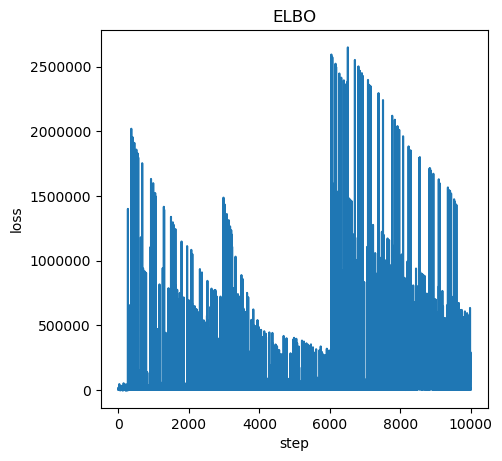

In [82]:
""" Super-simple use-case: learn each user's characteristic rate of betting. """
import torch
from torch.distributions import constraints
import pyro
import pyro.distributions as dist
import pyro.optim
import pyro.infer

pyro.clear_param_store()

def prior_model(data, users=all_users):
    n_users = len(users)
    bets = defaultdict(list)
    
    # Each user has a favorite average rate of betting.
    nbet_rates = pyro.sample(
        'nbet_rates',
        dist.Normal(torch.zeros(n_users), 1 + torch.zeros(n_users)))
    
    # Each user has a favorite average delay for betting.
    delay_rates = pyro.sample(
        'delay_rates',
        dist.Normal(torch.zeros(n_users), 10 + torch.zeros(n_users)))
    
    # Each user has a favorite way to spread out the bet probabilities.
    value_ccts = pyro.sample(
        'value_ccts',
        dist.Normal(1 + torch.zeros(n_users), 1 + torch.zeros(n_users)))
    
    for user_id, user in enumerate(users):
        # Each user chooses how many times they'll bet by sampling a Poisson distribution.
        n_bets = pyro.sample(
            'nbets_{}'.format(user),
            dist.Poisson(torch.abs(nbet_rates[user_id])))
        
        for bet_id in range(int(n_bets.item())):          
            # The delay of each bet is an i.i.d. sample from the exponential distribution.
            delay = pyro.sample(
                'delay_{}_{}'.format(user_id, bet_id),
                dist.Exponential(torch.abs(delay_rates[user_id])))
            
            # The value of each bet is an i.i.d. sample from a Dirichlet distribution.
            value = pyro.sample(
                'value_{}_{}'.format(user_id, bet_id),
                dist.Dirichlet(torch.abs(value_ccts[user_id]) * torch.ones(int(data['n_opts']))))
        
            bets[user].append(Bet(float(delay.detach().numpy()), value.detach().numpy()))
        
    return bets

def posterior_guide(data, users=all_users):
    n_users = len(users)
    
    # Define an amortized posterior for the number of bets rate.
    a = pyro.param('a_nbets', torch.randn(n_users, SENTENCE_DIM))
    b = pyro.param('b_nbets', torch.randn(n_users, 1))
    mean = torch.t(torch.FloatTensor(data['q_vector']))
    mean = torch.matmul(a, mean) + b
    bet_rates = pyro.sample('nbet_rates', dist.Delta(mean.squeeze()))

    # Define an amortized posterior for the bet delay rate.
    a = pyro.param('a_delays', torch.randn(n_users, SENTENCE_DIM))
    b = pyro.param('b_delays', torch.randn(n_users, 1))
    mean = torch.t(torch.FloatTensor(data['q_vector']))
    mean = torch.matmul(a, mean) + b
    delay_rates = pyro.sample('delay_rates', dist.Delta(mean.squeeze()))
    
    # Define an amortized posterior for the bet value concentration.
    a = pyro.param('a_values', torch.randn(n_users, SENTENCE_DIM))
    b = pyro.param('b_values', torch.randn(n_users, 1))
    mean = torch.t(torch.FloatTensor(data['q_vector']))
    mean = torch.matmul(a, mean) + b
    value_ccts = pyro.sample('value_ccts', dist.Delta(mean.squeeze()))
    
    return bet_rates, delay_rates, value_ccts

def conditioned_model(data, users):
    # This is the model conditioned on observed data, useful for training
    # the posterior (guide's) parameters to fit the data.
    obs_dict = {}
    for user_id, user in enumerate(users):
        true_n_bets = torch.FloatTensor([len(data['bets'][user])])
        obs_dict['nbets_{}'.format(user)] = true_n_bets
        for bet_id in range(int(true_n_bets.item())):
            true_delay = torch.FloatTensor([data['bets'][user][bet_id].delay])            
            obs_dict['delay_{}_{}'.format(user_id, bet_id)] = true_delay
            true_value = data['bets'][user][bet_id].value
            true_value = torch.FloatTensor(renormalize(true_value))
            obs_dict['value_{}_{}'.format(user_id, bet_id)] = true_value

    return pyro.condition(prior_model, data=obs_dict)(data, users)

def posterior_model(data, users):
    # This is the model conditioned on posterior parameters as sampled
    # from the guide, useful for drawing posterior samples.
    bet_rates, delay_rates, value_ccts = guide(data, users)
    obs_dict = {'nbet_rates': bet_rates, 'delay_rates': delay_rates, 'value_ccts': value_ccts}
    
    return pyro.condition(prior_model, data=obs_dict)(data, users)

svi = pyro.infer.SVI(model=conditioned_model,
                     guide=posterior_guide,
                     optim=pyro.optim.SGD({"lr": 0.0001}),
                     loss=pyro.infer.Trace_ELBO())

losses = []
means = []
usrs = set(all_users[:100])
tasks = task_ids[:100]

for t_id, t in enumerate(tqdm.tqdm_notebook(range(10000))):
    bets = get_data(np.random.choice(tasks), usrs)
    losses.append(svi.step(bets, list(usrs)))
    if t_id % 100 == 0:
         print(losses[-1])

plt.figure(figsize=(5, 5), facecolor='white', dpi=100)
plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss");

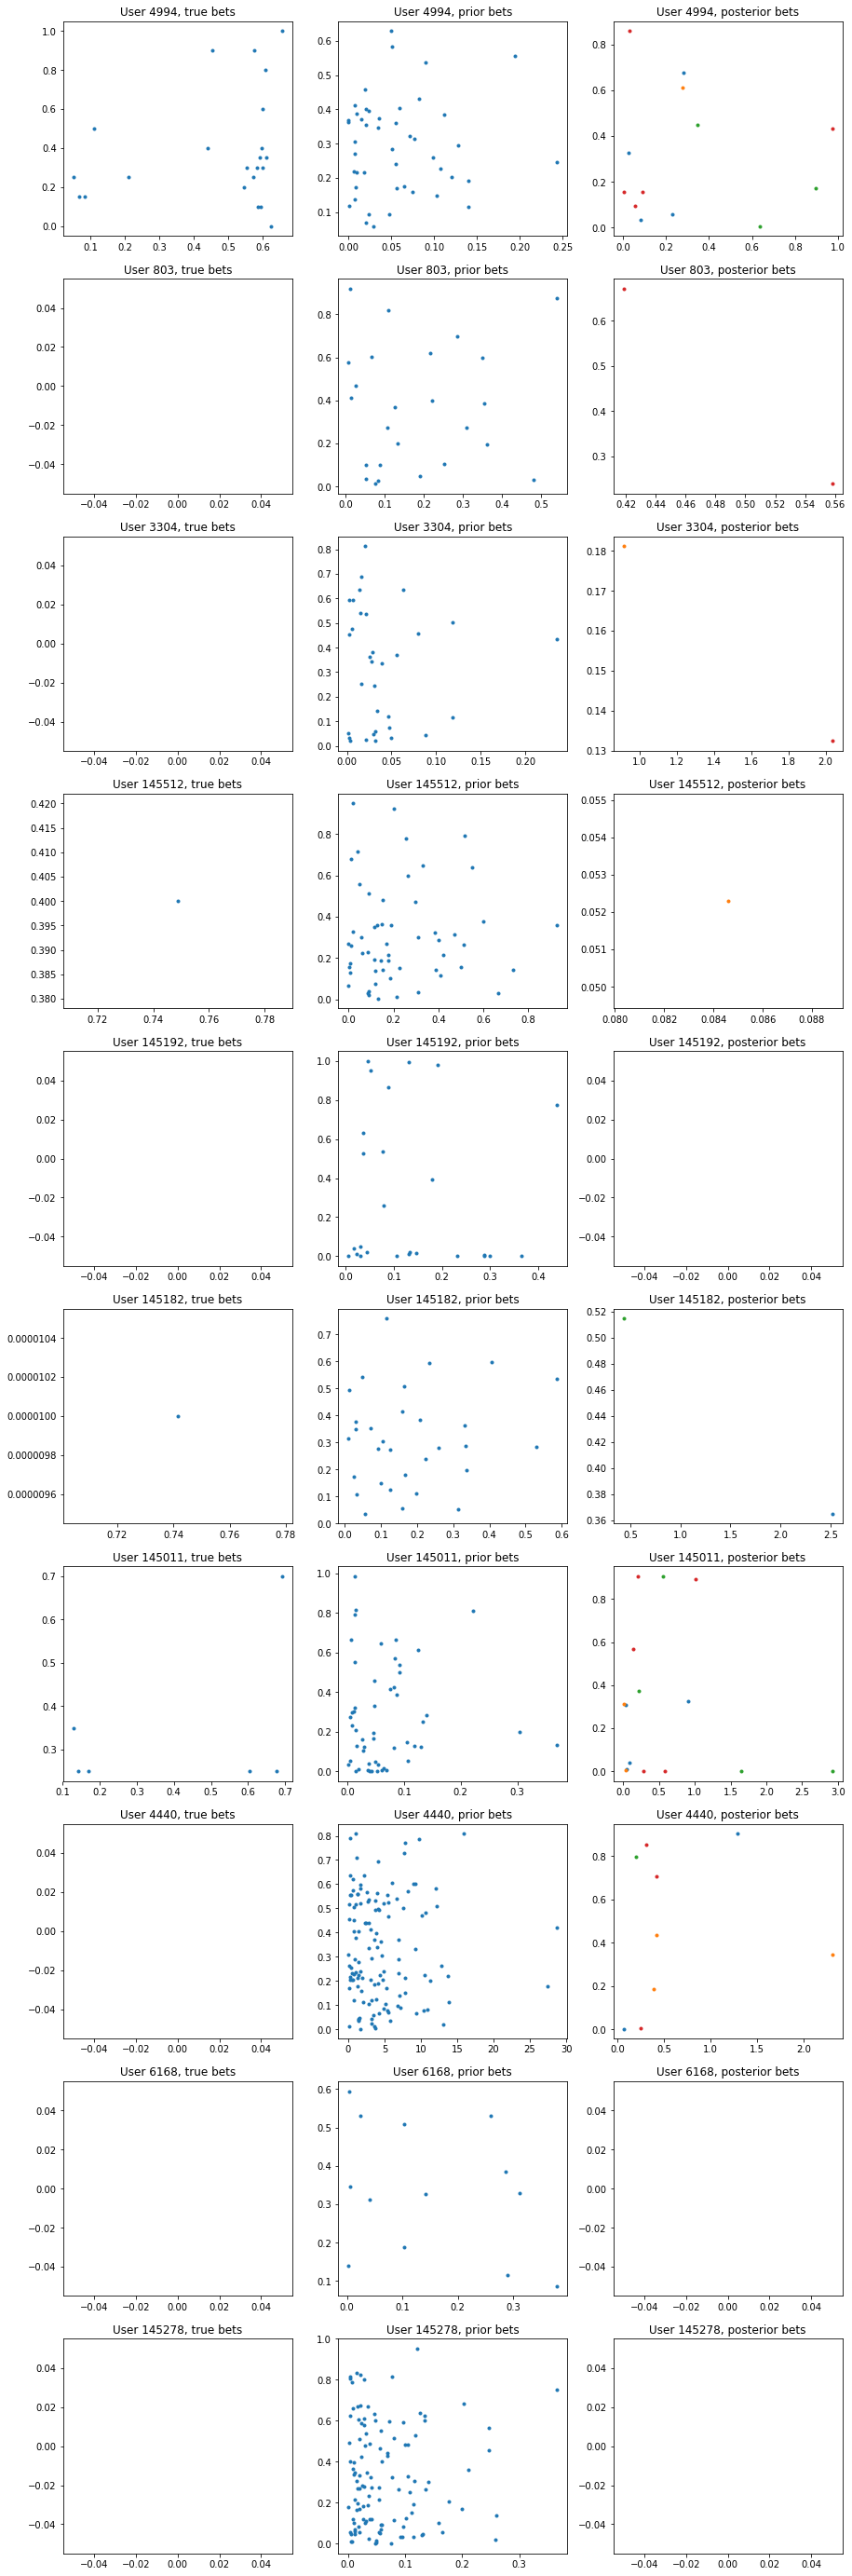

In [81]:
bets = get_data(task_ids[10], usrs)

def plot_samples(bets, usrs):
    # For each user, get the real data, a draw from the prior, and a draw from the posterior.
    true_bets = conditioned_model(bets, usrs)
    prior_bets = model(bets, usrs)
    plt.figure(figsize=(3 * 5, len(usrs) * 5), facecolor='white')

    for usr_id_id, usr_id in enumerate(usrs):
        plt.subplot2grid((len(usrs), 3), (usr_id_id, 0))
        delays = np.array([bet.delay for bet in true_bets[usr_id]])
        values = np.array([bet.value[0] for bet in true_bets[usr_id]])
        plt.plot(delays, values, '.')
        plt.title('User {}, true bets'.format(usr_id))

        plt.subplot2grid((len(usrs), 3), (usr_id_id, 1))
        delays = np.array([bet.delay for bet in prior_bets[usr_id]])
        values = np.array([bet.value[0] for bet in prior_bets[usr_id]])
        plt.plot(delays, values, '.')
        plt.title('User {}, prior bets'.format(usr_id))

        plt.subplot2grid((len(usrs), 3), (usr_id_id, 2))
        for draw in range(4):
            posterior_bets = posterior_model(bets, usrs)
            delays = np.array([bet.delay for bet in posterior_bets[usr_id]])
            values = np.array([bet.value[0] for bet in posterior_bets[usr_id]])
            plt.plot(delays, values, '.')
        plt.title('User {}, posterior bets'.format(usr_id))

        
plot_samples(bets, list(usrs))